
Extrapolation (Power 1-8 for training, 8-10 for testing)


C:\ProgramData\anaconda3\envs\MLP\lib\site-packages\pyro\poutine\subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 400/400 [11:14,  1.69s/it, step size=9.65e-04, acc. prob=0.883]
C:\Users\lg49jeki\AppData\Local\Temp\ipykernel_7084\799496624.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test_ext_scaled, dtype=torch.float32)  # Fixed to use test data


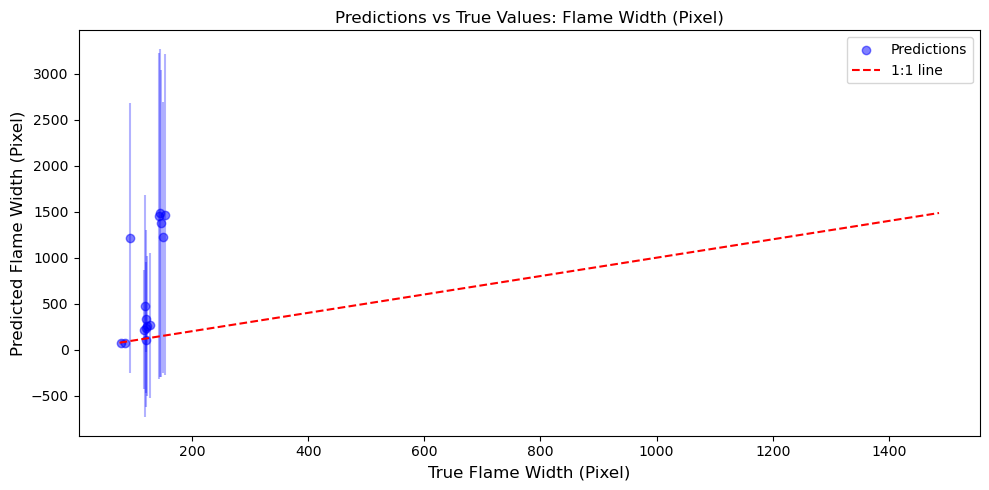

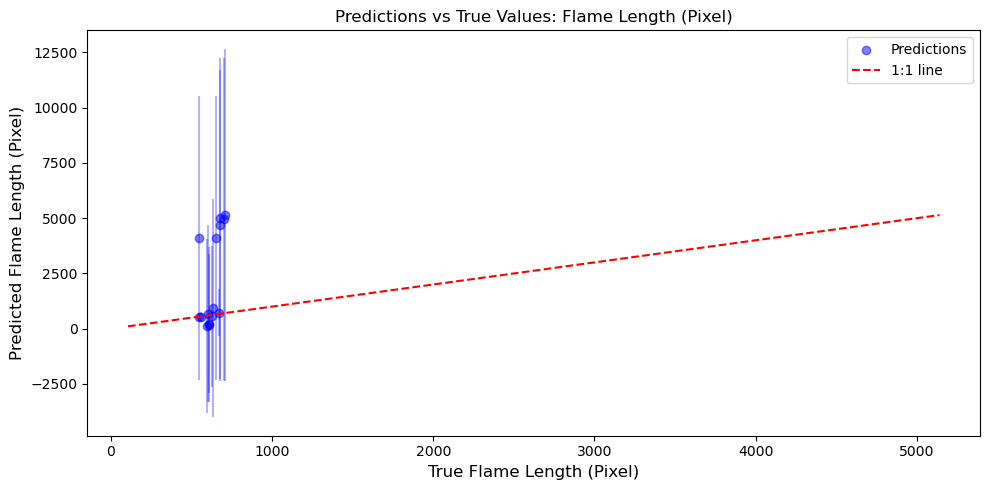

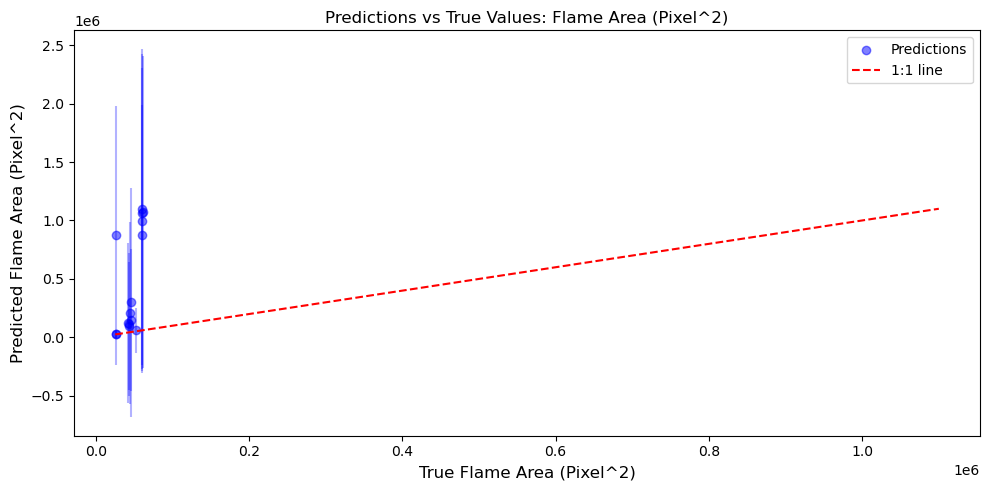

In [3]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# Define BNN model
class FlameBNN(PyroModule):
    def __init__(self, in_dim=4, out_dim=3, hid_dim=10, prior_scale=10.):
        super().__init__()
        
        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)
        
        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 4)  # Input has 4 dimensions (Power, Gas, Tangential, Axial)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x)
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1)).expand([x.shape[0]])  # Ensure sigma matches batch size
        
        with pyro.plate("data", x.shape[0]):  # Corrected line
            obs = pyro.sample("obs", dist.Normal(mu, sigma[:, None]).to_event(1), obs=y)
        return mu

# Initialize model
model = FlameBNN()

# Set random seed
pyro.set_rng_seed(42)

# Define MCMC
nuts_kernel = NUTS(model, jit_compile=True)
mcmc = MCMC(nuts_kernel, num_samples=200, warmup_steps=200)

# Assume df is loaded here (user needs to provide this)
# df = pd.read_csv('your_data.csv')  # Uncomment and specify your data file

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Extrapolation
print("\nExtrapolation (Power 1-8 for training, 8-10 for testing)")
df_train = df[df['Power'] <= 8]
df_test = df[df['Power'] > 8]
X_train_ext = df_train[['Power', 'Gas', 'Tangential', 'Axial']].to_numpy()
y_train_ext = df_train[['Flame Width AveragePixel', 'Flame Length Average Pixel', 'Flame Area Average Pixel^2']].to_numpy()
X_test_ext = df_test[['Power', 'Gas', 'Tangential', 'Axial']].to_numpy()
y_test_ext = df_test[['Flame Width AveragePixel', 'Flame Length Average Pixel', 'Flame Area Average Pixel^2']].to_numpy()
sample_names_train_ext = df_train.iloc[:, 0].to_numpy()
sample_names_test_ext = df_test.iloc[:, 0].to_numpy()

# Normalize extrapolation data
X_train_ext_scaled = scaler_X.fit_transform(X_train_ext)
y_train_ext_scaled = scaler_y.fit_transform(y_train_ext)
X_test_ext_scaled = scaler_X.transform(X_test_ext)
y_test_ext_scaled = scaler_y.transform(y_test_ext)

# Convert to tensors
X_train_ext_scaled = torch.tensor(X_train_ext_scaled, dtype=torch.float32)
y_train_ext_scaled = torch.tensor(y_train_ext_scaled, dtype=torch.float32)
X_test_ext_scaled = torch.tensor(X_test_ext_scaled, dtype=torch.float32)  # Added for predictions

# Run MCMC
mcmc.run(X_train_ext_scaled, y_train_ext_scaled)

# Get predictions
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
X_test = torch.tensor(X_test_ext_scaled, dtype=torch.float32)  # Fixed to use test data
preds = predictive(X_test)

# Plot predictions for each output dimension
def plot_predictions(preds, X_test, y_scaled, y_true, scaler_y):
    y_pred = preds['obs'].detach().numpy().mean(axis=0)  # Shape: (n_samples, 3)
    y_std = preds['obs'].detach().numpy().std(axis=0)    # Shape: (n_samples, 3)
    
    # Inverse transform predictions and true values
    y_pred_unscaled = scaler_y.inverse_transform(y_pred)
    y_true_unscaled = scaler_y.inverse_transform(y_scaled)
    
    # Standard deviation scaling (approximation, as std doesn't scale linearly)
    # Use scaling factor from scaler_y for approximation
    y_std_unscaled = y_std * (scaler_y.data_max_ - scaler_y.data_min_)
    
    output_names = ['Flame Width (Pixel)', 'Flame Length (Pixel)', 'Flame Area (Pixel^2)']
    
    for i in range(3):  # For each output dimension
        fig, ax = plt.subplots(figsize=(10, 5))
        
        # Plot true vs predicted
        ax.scatter(y_true_unscaled[:, i], y_pred_unscaled[:, i], c='blue', alpha=0.5, label='Predictions')
        ax.errorbar(y_true_unscaled[:, i], y_pred_unscaled[:, i], yerr=2*y_std_unscaled[:, i], 
                   fmt='none', c='blue', alpha=0.3)
        
        # Add 1:1 line
        min_val = min(y_true_unscaled[:, i].min(), y_pred_unscaled[:, i].min())
        max_val = max(y_true_unscaled[:, i].max(), y_pred_unscaled[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 line')
        
        ax.set_xlabel(f'True {output_names[i]}', fontsize=12)
        ax.set_ylabel(f'Predicted {output_names[i]}', fontsize=12)
        ax.set_title(f'Predictions vs True Values: {output_names[i]}')
        ax.legend()
        plt.tight_layout()
        plt.show()

# Generate plots
plot_predictions(preds, X_test_ext_scaled, y_test_ext_scaled, y_test_ext, scaler_y)